In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# linux command to change directory
%cd /content/gdrive/MyDrive/Coding/Afnan/Models

/content/gdrive/MyDrive/Coding/Afnan/Models


In [ ]:
# linux command to list files in current directory
!ls

Bert.ipynb     CNN.ipynb   LSTM_With_BI-LSTM.ipynb
Bi-LSTM.ipynb  Embedding   model.png
checkPoints    LSTM.ipynb  preprocessed.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec, KeyedVectors
import os
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import pad_sequences, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding , Dense , Conv1D, Dropout,Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# loading processed text
data = pd.read_csv('preprocessed.csv')
data = data[['Text','Compartive']]
data.head()

,Text,Compartive
0,يقولك تطبيقات ابل افضل سامسونغ اعرف دفيع واهبل...,1
1,معليش لازم نكون نفسك نصير سبايك داءما حقين ا...,1
2,تر ابل افضل شركات الجولات الاستخدام عشان الن...,1
3,وجهه نظري ابل افضل ناحيه الاستخدام العام الان...,1
4,جهاز متصل بالنت فاهو جهاز امن بس الحق ينقال...,1


In [ ]:
# split data into training and tesing its size is 15% of dataset
x_train, x_test, y_train, y_test = train_test_split(data['Text'],data['Compartive']
                                                    ,test_size=0.15,random_state=44)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((479,), (479,), (85,), (85,))

In [ ]:
# define tokenizer 
# let's say we have a sentence "she is going to school" , tokenizer convert it in inteligent
# way into she is go ##ing to school , ## mean than the words is belong to the previous
tokenizer = Tokenizer()
# fit the tokenzier into out the dataset
tokenizer.fit_on_texts(data['Text'])
# word_index contains the word and its index
wordIndex = tokenizer.word_index
# check the word index by getting the index of the word "افضل"
print(list(wordIndex.items())[:10])

[('ابل', 1), ('افضل', 2), ('سامسونج', 3), ('نظام', 4), ('اندرويد', 5), ('شركه', 6), ('بس', 7), ('الاندرويد', 8), ('ناحيه', 9), ('اجهزه', 10)]


In [ ]:
max_len = 35
# Because Tokenizer.word_index is a python dictionary that contains token keys (string) and
# token ID values (integer), and where the first token ID is 1 (not zero) and 
# where the token IDs are assigned incrementally. Therefore, the greatest token ID
# in word_index is len(word_index). Therefore, we need vocabulary of size len(word_index) + 1 to
# be able to index up to the greatest token ID.
vocab_len = len(wordIndex) + 1
print(f'Max length of words in  {max_len}')
print(f'Number of Words {vocab_len}')

Max length of words in  35
Number of Words 3421


In [ ]:
# embedding dictionary to save all words and its embedding vector in it
w2vEmbedding_index = {}
# the size of embedding vector
emb_dimension = 300
# the path of embedding file
embeddings_file="Embedding/tweets_cbow_300"
# load word2vec model with its pretrained embedding
w2v_model =KeyedVectors.load(embeddings_file)
# loop over the words in word2vec vocab
for word in w2v_model.wv.vocab:
  # assign the word as a key and its vector as a value in dictionary
  w2vEmbedding_index[word] = w2v_model.wv[word]

In [ ]:
# define embedding matrix that model will use and it has all words in our dataset
# its dimension number of words , size of vector
embedding_matrix = np.zeros((vocab_len,emb_dimension))
# loop voer the words in word_index 
for word,i in tokenizer.word_index.items():
  # get embedding vector from embedding dictionary that has all words representations
  embedding_vector = w2vEmbedding_index.get(word)
  # check that embedding vector is not equal to None
  if embedding_vector is not None:
    # assign embedding vector to martix
    embedding_matrix[i] = embedding_vector

print("Embedding Matrix shape:", embedding_matrix.shape)

Embedding Matrix shape: (3421, 300)


In [ ]:
# convert each word in the text into a integer 
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# pad_sequences is used to ensure that all sequences in a list have the same length
# By default this is done by padding 0 in the beginning 
# of each sequence until each sequence has the same length as the longest sequence.
# padding = 'post' to make padding done 0 in the ending of the sequence

x_train = pad_sequences(x_train,maxlen=max_len, padding='post')
x_test = pad_sequences(x_test,maxlen=max_len, padding='post')

In [ ]:
x_train.shape

(479, 35)

In [ ]:
model = Sequential([
    # Embedding is used to gets the Representation of Every Input sequences,
    # by defult it is initilized Randomly , but here we will load our weights from Embedding Matrix
    # and set it Non Trainable  
    Embedding(vocab_len,emb_dimension,weights=[embedding_matrix],
              trainable=False,input_length=max_len),
    # CNN layer with 256 filter and its kernel size is 3
    Conv1D(256,3,padding='same',activation='relu'),
    # flatten is used convert cnn output into 1D array to pass it into Fully Connected Layers
    Flatten(),
    # Define Fully Conntected with 128 Neuron and Relu activation Function
    Dense(128,activation='relu'),
    # Dropout is used to reduce Overfiting
    Dropout(.5),
    Dense(1,activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 300)           1026300   
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 256)           230656    
                                                                 
 flatten_2 (Flatten)         (None, 8960)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1147008   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,404,093
Trainable params: 1,377,793
No

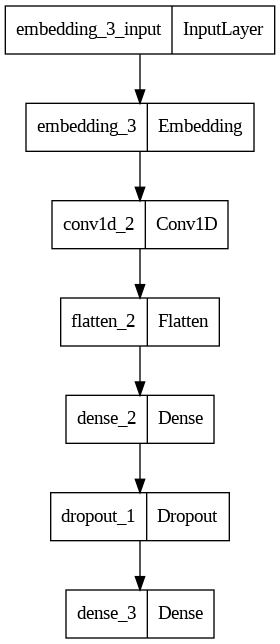

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Stop training when a monitored metric has stopped improving.
  # monitor > Quantity to be monitored
  # patience > Number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_accuracy',patience=2,mode='max')

# os.getcwd is used to get path of current direcotry then pass it to join function that used to joining
# two file pathes 
file_path = os.path.join(os.getcwd(),"checkPoints/CNN/model.h5")
check_point = ModelCheckpoint(filepath=file_path,
                              # monitor is the metrics that we want to optimize
                              monitor='val_accuracy',
                              # mode tells that we look for maximize this monitor
                              mode='max',
                              # ensure that the lasest best model (accroding to the metrics) will not
                              # change
                              save_best_only=True,
                              save_wrights_only=True,
                              #set logs notification during model training
                              verbose=1)

In [ ]:
history = model.fit(x_train,y_train,validation_data=[x_test,y_test],epochs=5,
                    callbacks=[early_stop,check_point])

Epoch 1/5
15/15 [==============================] - 2s 59ms/step - loss: 0.6934 - accuracy: 0.8142 - val_loss: 0.3902 - val_accuracy: 0.8353
Epoch 2/5
15/15 [==============================] - 1s 42ms/step - loss: 0.3240 - accuracy: 0.8810 - val_loss: 0.3630 - val_accuracy: 0.8824
Epoch 3/5
15/15 [==============================] - 1s 42ms/step - loss: 0.2052 - accuracy: 0.9248 - val_loss: 0.3697 - val_accuracy: 0.8824
Epoch 4/5
15/15 [==============================] - 1s 41ms/step - loss: 0.1305 - accuracy: 0.9541 - val_loss: 0.3934 - val_accuracy: 0.8824
Epoch 5/5
15/15 [==============================] - 1s 41ms/step - loss: 0.0685 - accuracy: 0.9749 - val_loss: 0.4364 - val_accuracy: 0.8824


In [ ]:
def plot_graph(history,string):
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='Validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show
  

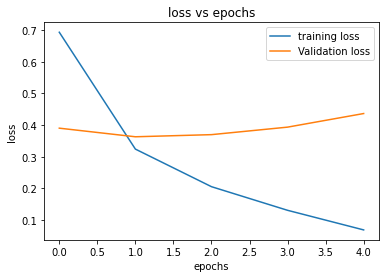

In [ ]:
plot_graph(history,'loss')

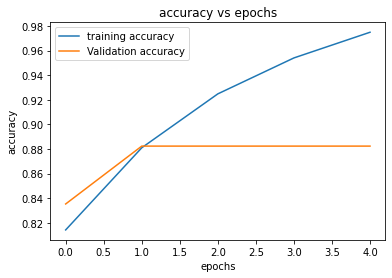

In [ ]:
plot_graph(history,'accuracy')

In [ ]:
y_predict = np.round(model.predict(x_test))
y_predict[:10]

NameError: ignored

In [ ]:
acc_score = accuracy_score(y_test, y_predict)
print(f"Accuracy of our model is {acc_score}")

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
confusion = confusion_matrix(y_test, y_predict)
display = ConfusionMatrixDisplay(confusion,display_labels=['None',"Compartive"])
display.plot(ax=ax)
plt.show()